# XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from xgboost import XGBClassifier

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import json

### Load the Training, Testing and Evaluation Data

In [4]:
# Load the data
X_train = pd.read_pickle('model/X_train.pkl')
y_train = pd.read_pickle('model/y_train.pkl')
X_test = pd.read_pickle('model/X_test.pkl')
y_test = pd.read_pickle('model/y_test.pkl')
X_recommend = pd.read_pickle('model/X_recommend.pkl')

In [5]:
X_train.head()

,popularity,explicit,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,...,urban contemporary,vallenato,vapor trap,vapor twitch,video game music,viral pop,viral rap,weirdcore,west coast rap,yacht rock
1213,4,False,220653,0.780,0.856,10,-5.316,0,0.0405,0.11600,...,0,0,0,0,0,0,0,0,0,0
71,84,False,173333,0.726,0.431,8,-8.765,0,0.1350,0.73100,...,0,0,0,0,0,0,0,0,0,0
1058,0,False,182506,0.791,0.907,0,-2.223,1,0.0884,0.01320,...,0,0,0,0,0,0,0,0,0,0
756,77,True,205158,0.533,0.858,2,-4.212,1,0.0766,0.00021,...,0,0,0,0,0,0,0,0,0,0
317,62,False,109735,0.670,0.609,7,-10.088,1,0.0333,0.74900,...,0,0,0,0,0,0,0,0,0,0


Since XGBoost is an ensemble algorithm comprised of decision trees which is a Tree-based algorithm, it is fairly insensitive to the scale of the features, thus we wont scale the features for this model.

### Hyperparameter Tuning

We will tune for:
- Step size shrinkage, must be in range [0,1] (eta)
- Maximum depth of a tree (max_depth)
- Minimum sum of instance weight needed in a child (min_child_weight)

In [6]:
# Check accuracy for each value for each hyperparameter in its range
# We will use GridSearchCV to automate this process

eta = [0.2, 0.3, 0.4, 0.5]
max_depth = [0.3, 0.5, 0.8, 1]
min_child_weight = [3, 4, 5, 8, 12, 16, 20]

#Convert to dictionary
hyperparameters = dict(eta=eta,
                      max_depth=max_depth,
                      min_child_weight=min_child_weight)

print(hyperparameters)

{'eta': [0.2, 0.3, 0.4, 0.5], 'max_depth': [0.3, 0.5, 0.8, 1], 'min_child_weight': [3, 4, 5, 8, 12, 16, 20]}


In [7]:
# estimator = ML model to be tested
# param_grid = dictionary of hyperparameters to be tested
# n_jobs = number of cores to be used in parallel, -1 means use all
# cv = number of cross validation set elements
# verbose = setting it to 2 will print updates to the terminal

best_model = GridSearchCV(estimator=XGBClassifier(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/Users/veersingh/opt/anaconda3/envs/recsysspotify/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.7652135  0.76853994 0.75770661
 0.74604683 0.74437328 0.74438017 0.74439394        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.7652135  0.76437328 0.75688017 0.74353994 0.75436639
 0.74188705 0.73190083        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan       

[14:23:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [8]:
eta = best_model.best_estimator_.get_params()['eta']
max_depth = best_model.best_estimator_.get_params()['max_depth']
min_child_weight = best_model.best_estimator_.get_params()['min_child_weight']

print(f'Best eta: {eta}')
print(f'Best max_depth: {max_depth}')
print(f'Best min_child_weight: {min_child_weight}')

Best eta: 0.5
Best max_depth: 1
Best min_child_weight: 3


### Model

In [9]:
# model
xg_boost = XGBClassifier(eta=eta,
                        max_depth=max_depth,
                        min_child_weight=min_child_weight)

# fit the model
xg_boost.fit(X_train, y_train)

# prediction
predictions = xg_boost.predict(X_test)

[14:24:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Visualizing the Confusion Matrix

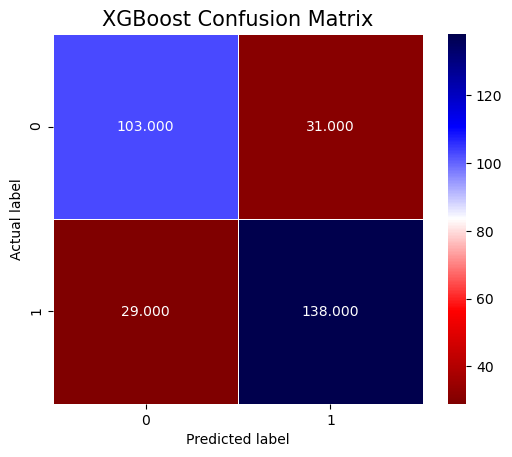

In [10]:
cm = confusion_matrix(y_test, predictions)
plt.figure()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'seismic_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('XGBoost Confusion Matrix', size = 15);
plt.show()

In [11]:
precision_macro_average = precision_score(y_test, predictions, average='macro')
precision_weighted_average = precision_score(y_test, predictions, average='weighted')

recall_macro_average = recall_score(y_test, predictions, average='macro')
recall_weighted_average = recall_score(y_test, predictions, average='weighted')

f1_macro_average = f1_score(y_test, predictions, average='macro')
f1_weighted_average = f1_score(y_test, predictions, average='weighted')


print(f'Precision (macro average)--> {round(precision_macro_average*100, 2)}%')
print(f'Precision (weighted average)--> {round(precision_weighted_average*100, 2)}%')

print(f'Recall (macro average)--> {round(recall_macro_average*100, 2)}%')
print(f'Recall (weighted average)--> {round(recall_weighted_average*100, 2)}%')

print(f'F1 score (macro average)--> {round(f1_macro_average*100, 2)}%')
print(f'F1 score (weighted average)--> {round(f1_weighted_average*100, 2)}%')

Precision (macro average)--> 79.84%
Precision (weighted average)--> 80.04%
Recall (macro average)--> 79.75%
Recall (weighted average)--> 80.07%
F1 score (macro average)--> 79.79%
F1 score (weighted average)--> 80.05%


In [12]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77       134
           1       0.82      0.83      0.82       167

    accuracy                           0.80       301
   macro avg       0.80      0.80      0.80       301
weighted avg       0.80      0.80      0.80       301



#### This model was good

In [13]:
# Serialize f1 scores into a json file for later comparison between all models
model_name = "xg_boost"
entry = {"f1_macro_average":f1_macro_average, "f1_weighted_average":f1_weighted_average}


with open("f1_scores.json", "r") as file:
    data = json.load(file)
data[model_name] = entry
with open("f1_scores.json", "w") as file:
    json.dump(data, file, indent=4)